c:\Users\nick\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


<class 'pandas.core.frame.DataFrame'>
Index: 637 entries, 4 to 640
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Unnamed: 0                637 non-null    int64         
 1   ds                        637 non-null    datetime64[ns]
 2   open_price                637 non-null    float64       
 3   high_price                637 non-null    float64       
 4   low_price                 637 non-null    float64       
 5   y                         637 non-null    float64       
 6   volume                    637 non-null    int64         
 7   foreign                   637 non-null    int64         
 8   investment                637 non-null    int64         
 9   dealer                    637 non-null    int64         
 10  ratio_over_400_shares     637 non-null    float64       
 11  shareholders_400_to_600   637 non-null    int64         
 12  shareholders_600_to_800   6

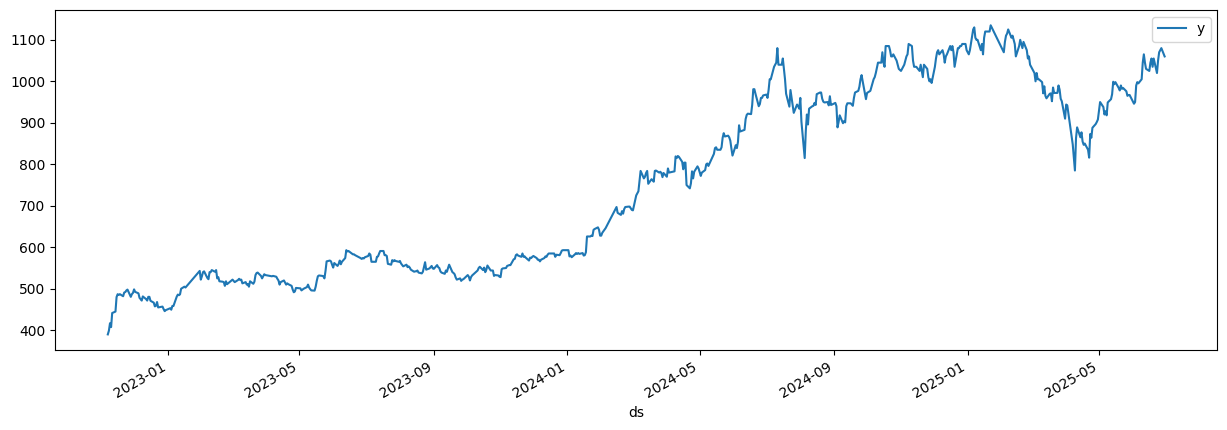

In [1]:
import pandas as pd
from sklearn.model_selection import ParameterGrid
from neuralprophet import NeuralProphet, set_log_level, set_random_seed

from src.model.features import add_stock_price_feature

# Disable logging messages unless there is an error
set_log_level("ERROR")

SYMBOL = '2330'
# NAME = '台積電'
# SYMBOL = '2301'
# NAME = '光寶科'

df = pd.read_csv(f'data/stocks/{SYMBOL}_stock_data_0630.csv', parse_dates=['ds'])
df = add_stock_price_feature(df)
plt = df.plot(x="ds", y="y", figsize=(15, 5))
df.info()

In [26]:
llm_factor = pd.read_csv(f'reports/pred_{SYMBOL}_grok.csv', parse_dates=True, index_col=0)
llm_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 158 entries, 2024-11-01 to 2025-06-30
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   factor        158 non-null    float64
 1   explanation   158 non-null    object 
 2   updated_time  158 non-null    object 
 3   news_count    158 non-null    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ KB


In [27]:
exp = llm_factor[['explanation']]

counts = exp["explanation"].value_counts()
print(counts)

explanation
OK    158
Name: count, dtype: int64


In [28]:
counts = llm_factor['factor'].value_counts().sort_values()
print(counts)

factor
-0.8     1
 1.0     1
 1.2     1
-4.2     1
-2.1     1
-1.8     2
 4.5     2
-3.5     2
 2.1     3
-1.5     5
 3.5     5
 1.8     6
-2.5    13
 2.0    22
 1.5    34
 2.5    59
Name: count, dtype: int64


In [29]:
llm_factor = llm_factor[~llm_factor.index.duplicated(keep='first')]
llm_factor = llm_factor[['factor']]
llm_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 158 entries, 2024-11-01 to 2025-06-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   factor  158 non-null    float64
dtypes: float64(1)
memory usage: 6.5 KB


In [30]:
df_merged = df.merge(llm_factor, how='left', left_on='ds', right_index=True)
df_merged[df_merged['factor'].isnull()]

,Unnamed: 0,ds,open_price,high_price,low_price,y,volume,foreign,investment,dealer,ratio_over_400_shares,shareholders_400_to_600,shareholders_600_to_800,shareholders_800_to_1000,ratio_over_1000_shares,high_low_diff,MA,factor
4,4,2022-11-07,390.0,393.0,387.0,390.0,37704746,6340764,51000,294538,87.96,477,297,203,85.57,6.0,388.5,NaN
5,5,2022-11-08,395.0,399.5,394.0,399.0,32576136,13879259,282000,-1503394,87.96,477,297,203,85.57,5.5,390.0,NaN
6,6,2022-11-09,403.5,417.0,403.5,417.0,56357663,14292115,615330,-625324,87.96,477,297,203,85.57,13.5,394.4,NaN
7,7,2022-11-10,409.0,411.5,406.0,407.5,33671621,-6792955,248000,-1423745,87.96,477,297,203,85.57,5.5,399.1,NaN
8,8,2022-11-11,441.5,442.0,435.0,441.5,83770040,45794052,1847814,-4270316,87.96,477,297,203,85.57,7.0,411.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478,478,2024-10-25,1065.0,1070.0,1060.0,1065.0,23347890,5544107,-454985,31122,89.87,547,321,204,87.25,10.0,1069.0,NaN
479,479,2024-10-28,1075.0,1080.0,1050.0,1050.0,41665065,3220031,398556,491518,89.83,556,322,204,87.20,30.0,1062.0,NaN
480,480,2024-10-29,1035.0,1040.0,1020.0,1040.0,48097705,-1955334,1073752,-711061,89.83,556,322,204,87.20,20.0,1055.0,NaN
481,481,2024-10-30,1040.0,1055.0,1030.0,1030.0,40765247,-2902993,716936,53964,89.83,556,322,204,87.20,25.0,1049.0,NaN


In [31]:
df_merged['factor'] = df_merged['factor'].fillna(0)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 637 entries, 4 to 640
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Unnamed: 0                637 non-null    int64         
 1   ds                        637 non-null    datetime64[ns]
 2   open_price                637 non-null    float64       
 3   high_price                637 non-null    float64       
 4   low_price                 637 non-null    float64       
 5   y                         637 non-null    float64       
 6   volume                    637 non-null    int64         
 7   foreign                   637 non-null    int64         
 8   investment                637 non-null    int64         
 9   dealer                    637 non-null    int64         
 10  ratio_over_400_shares     637 non-null    float64       
 11  shareholders_400_to_600   637 non-null    int64         
 12  shareholders_600_to_800   6

In [32]:
df_merged['pred'] = (df_merged['factor']/100 * df_merged['y'] + df_merged['y']).shift(1)

df_merged.dropna(inplace=True)

df_merged

,Unnamed: 0,ds,open_price,high_price,low_price,y,volume,foreign,investment,dealer,ratio_over_400_shares,shareholders_400_to_600,shareholders_600_to_800,shareholders_800_to_1000,ratio_over_1000_shares,high_low_diff,MA,factor,pred
5,5,2022-11-08,395.0,399.5,394.0,399.0,32576136,13879259,282000,-1503394,87.96,477,297,203,85.57,5.5,390.0,0.0,390.000
6,6,2022-11-09,403.5,417.0,403.5,417.0,56357663,14292115,615330,-625324,87.96,477,297,203,85.57,13.5,394.4,0.0,399.000
7,7,2022-11-10,409.0,411.5,406.0,407.5,33671621,-6792955,248000,-1423745,87.96,477,297,203,85.57,5.5,399.1,0.0,417.000
8,8,2022-11-11,441.5,442.0,435.0,441.5,83770040,45794052,1847814,-4270316,87.96,477,297,203,85.57,7.0,411.0,0.0,407.500
9,9,2022-11-14,450.0,450.0,441.5,445.0,63282094,14430202,268000,-3869533,88.24,477,302,207,85.82,8.5,422.0,0.0,441.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,636,2025-06-24,1045.0,1050.0,1040.0,1050.0,30105394,11174810,31308,94002,89.29,538,319,231,86.61,10.0,1043.0,2.5,994.500
637,637,2025-06-25,1060.0,1070.0,1055.0,1070.0,44519173,23558545,9183,-180321,89.29,538,319,231,86.61,15.0,1046.0,1.5,1076.250
638,638,2025-06-26,1075.0,1080.0,1065.0,1075.0,39534708,19172913,18419,-1688998,89.29,538,319,231,86.61,15.0,1054.0,2.1,1086.050
639,639,2025-06-27,1070.0,1080.0,1060.0,1080.0,34877892,12287519,-687470,-2257313,89.29,538,319,231,86.61,20.0,1059.0,2.0,1097.575


In [33]:
from datetime import datetime

val_df = df_merged[df_merged['ds'] >= datetime(2024, 12, 18)]

val_df

,Unnamed: 0,ds,open_price,high_price,low_price,y,volume,foreign,investment,dealer,ratio_over_400_shares,shareholders_400_to_600,shareholders_600_to_800,shareholders_800_to_1000,ratio_over_1000_shares,high_low_diff,MA,factor,pred
515,515,2024-12-18,1075.0,1090.0,1070.0,1085.0,47331164,12563764,-190094,-908000,89.80,549,310,210,87.21,20.0,1074.0,2.5,1091.125
516,516,2024-12-19,1065.0,1070.0,1055.0,1070.0,46126529,-6196173,424691,315314,89.80,549,310,210,87.21,15.0,1076.0,1.5,1112.125
517,517,2024-12-20,1060.0,1060.0,1035.0,1035.0,56392109,-22205208,3414,499497,89.80,549,310,210,87.21,25.0,1070.0,-2.5,1086.050
518,518,2024-12-23,1065.0,1080.0,1060.0,1080.0,32800319,17701276,552800,862212,89.82,542,314,208,87.24,20.0,1069.0,3.5,1009.125
519,519,2024-12-24,1095.0,1095.0,1080.0,1080.0,30069757,6112744,-12360,532047,89.82,542,314,208,87.24,15.0,1070.0,2.5,1117.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,636,2025-06-24,1045.0,1050.0,1040.0,1050.0,30105394,11174810,31308,94002,89.29,538,319,231,86.61,10.0,1043.0,2.5,994.500
637,637,2025-06-25,1060.0,1070.0,1055.0,1070.0,44519173,23558545,9183,-180321,89.29,538,319,231,86.61,15.0,1046.0,1.5,1076.250
638,638,2025-06-26,1075.0,1080.0,1065.0,1075.0,39534708,19172913,18419,-1688998,89.29,538,319,231,86.61,15.0,1054.0,2.1,1086.050
639,639,2025-06-27,1070.0,1080.0,1060.0,1080.0,34877892,12287519,-687470,-2257313,89.29,538,319,231,86.61,20.0,1059.0,2.0,1097.575


In [34]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(val_df['y'], val_df['pred']) * 100

2.7990692254880987

In [35]:
df_merged['pred_b'] = df_merged['factor'] >= 0

df_merged['test_b'] = df_merged['y'].diff() >= 0

df_merged

val_df = df_merged[df_merged['ds'] >= datetime(2024, 12, 18)]

val_df

,Unnamed: 0,ds,open_price,high_price,low_price,y,volume,foreign,investment,dealer,...,shareholders_400_to_600,shareholders_600_to_800,shareholders_800_to_1000,ratio_over_1000_shares,high_low_diff,MA,factor,pred,pred_b,test_b
515,515,2024-12-18,1075.0,1090.0,1070.0,1085.0,47331164,12563764,-190094,-908000,...,549,310,210,87.21,20.0,1074.0,2.5,1091.125,True,True
516,516,2024-12-19,1065.0,1070.0,1055.0,1070.0,46126529,-6196173,424691,315314,...,549,310,210,87.21,15.0,1076.0,1.5,1112.125,True,False
517,517,2024-12-20,1060.0,1060.0,1035.0,1035.0,56392109,-22205208,3414,499497,...,549,310,210,87.21,25.0,1070.0,-2.5,1086.050,False,False
518,518,2024-12-23,1065.0,1080.0,1060.0,1080.0,32800319,17701276,552800,862212,...,542,314,208,87.24,20.0,1069.0,3.5,1009.125,True,True
519,519,2024-12-24,1095.0,1095.0,1080.0,1080.0,30069757,6112744,-12360,532047,...,542,314,208,87.24,15.0,1070.0,2.5,1117.800,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,636,2025-06-24,1045.0,1050.0,1040.0,1050.0,30105394,11174810,31308,94002,...,538,319,231,86.61,10.0,1043.0,2.5,994.500,True,True
637,637,2025-06-25,1060.0,1070.0,1055.0,1070.0,44519173,23558545,9183,-180321,...,538,319,231,86.61,15.0,1046.0,1.5,1076.250,True,True
638,638,2025-06-26,1075.0,1080.0,1065.0,1075.0,39534708,19172913,18419,-1688998,...,538,319,231,86.61,15.0,1054.0,2.1,1086.050,True,True
639,639,2025-06-27,1070.0,1080.0,1060.0,1080.0,34877892,12287519,-687470,-2257313,...,538,319,231,86.61,20.0,1059.0,2.0,1097.575,True,True


Confusion Matrix:
 [[66  2]
 [38 20]]


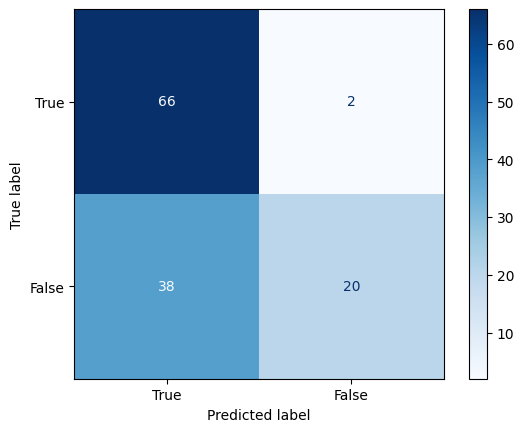

In [36]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert boolean to integers (optional, sklearn can handle bools too)
y_true = val_df["test_b"].astype(int)
y_pred = val_df["pred_b"].astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[1,0])  # order: [Positive, Negative]
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["True", "False"])
disp.plot(cmap="Blues")
plt.show()

In [37]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report

precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
accuracy  = accuracy_score(y_true, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"Accuracy:  {accuracy:.2f}")

Precision: 0.63
Recall:    0.97
Accuracy:  0.68
